In [22]:
import os
import re
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm
from geopy.geocoders import Nominatim, ArcGIS, GoogleV3, OpenMapQuest
from geolite2 import geolite2
import datetime
import calendar
import random
nominatim = Nominatim(timeout=100)
from matplotlib import rcParams
rcParams.update({'font.size': 24})


In [68]:
class Conference(object):
    
    def __init__(self, initials=None, name=None, place=None):
        if "2017" in initials:
            self.initials = initials.replace("2017", "").replace("-17", "")
        else:
            self.initials = initials
        self.name = name
        self.place = place
        self.start = datetime.datetime(2017, 1, 1, 0, 0)
        self.end = datetime.datetime(2018, 1, 1, 0, 0)
        self.location = (random.randrange(-80, 80), random.randrange(-180, 180))
        
    def get_dates(self, timestring):
        """
        Get initial and final dates (datetime objects)
        by converting a time string from the CSV file
        """
        match = re.search(r'(\w+) (\d+)-(\d+), (\d{4})', timestring)
        if match:
            month, daystart, dayend, year = match[1], match[2], match[3], match[4]
            self.start = datetime.datetime.strptime(" ".join((month, daystart, year)),
                                           '%B %d %Y')
            self.end = datetime.datetime.strptime(" ".join((month, dayend, year)),
                                         '%B %d %Y')
    
    def get_location(self, locationstring):
        """
        Get the coordinates from the place description (city, country)
        """
        
        loc = nominatim.geocode(locationstring)

        # if it returns a location
        if loc is not None:
            self.location = (loc.latitude, loc.longitude)

In [3]:
def getOverlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]-1))

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()


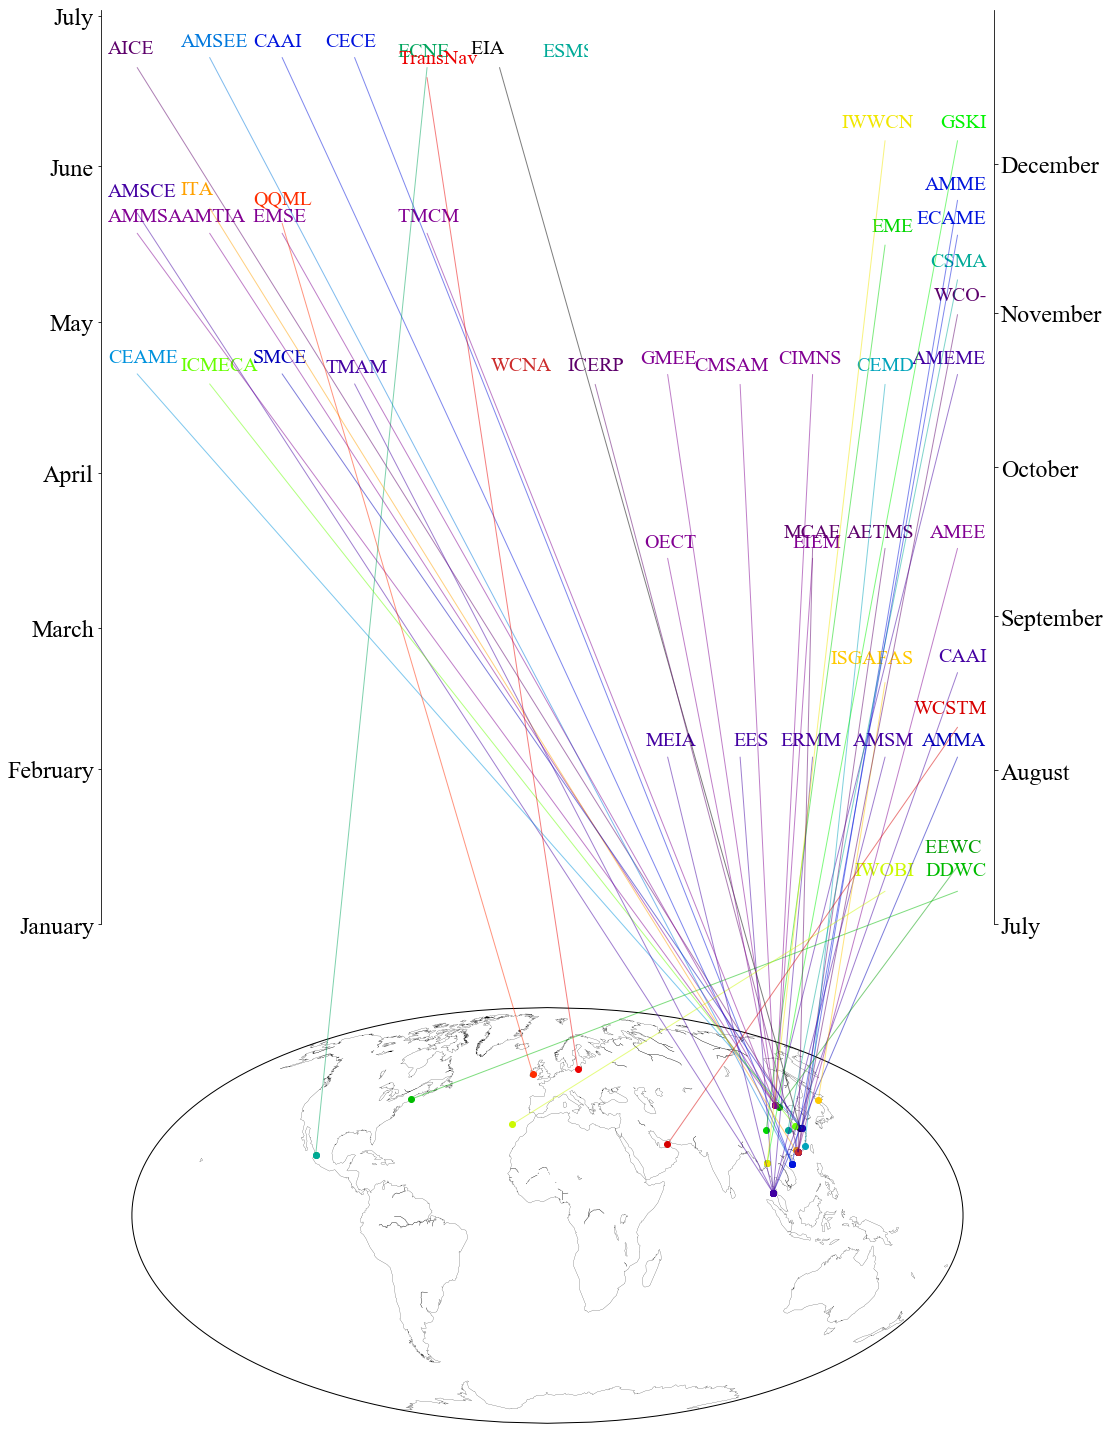

In [71]:
datafile = "FakeConferences.tsv"
# datafile = "testfile.csv"
conferencelist =[]
startlist = []
endlist = []
placelist = []
cmap = cm.get_cmap('nipy_spectral')

tstart = datetime.datetime(2017, 1, 1, 0, 0).timestamp()
tmid = datetime.datetime(2017, 7, 1, 0, 0).timestamp()
tend= datetime.datetime(2018, 1, 1, 0, 0).timestamp()
tdiff = tend - tstart

f = plt.figure(figsize=(16, 26))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=2)
ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=2)
ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
m = Basemap(projection='moll',lon_0=0,resolution='c')
m.ax = ax3

with open(datafile, 'r') as f:
    for lines in f:
        c = Conference(initials=lines.split('\t')[0],
                       name=lines.split('\t')[1],
                       place=lines.split('\t')[2])
        c.get_dates(lines.split('\t')[3])
        c.end += datetime.timedelta(days=1)
        c.get_location(lines.split('\t')[2])
        
        timestart = c.start.timestamp()
        timeend = c.end.timestamp()
                
        # print(c.location)
        
        startlist.append(timestart)
        endlist.append(timeend)
        # Compute the number of overlaps
        
        noverlap = 0
        for start, end in zip(startlist, endlist):
            overlap = getOverlap([timestart, timeend], [start, end])
            if overlap:
                noverlap += 1
                #print(noverlap)
        
        try:
            placeindex = placelist.index(c.place)
        except ValueError:
            placelist.append(c.place)
            placeindex = len(placelist)
            
        # print("noverlap = {}".format(noverlap))
        # thiscolor = cmap((timestart - tstart) / tdiff)
        thiscolor = cmap((placeindex/24))
        
        # Add points on the map
        lon, lat = m(c.location[1], c.location[0])
        m.plot(lon, lat, 'ko', latlon=False, color=thiscolor)
        xy2 = (lon, lat)
        
        # Write the text along the corresponding date
        # left side for January to June
        # right side for the rest of the year
        
        spacefact = 2.5
        if c.start.month <= 6:
            
            #ax1.add_patch(Rectangle((spacefact * noverlap + .05, timestart), 
            #                        spacefact, timeend - timestart,
            #                        alpha=0.2, fill=True, color=thiscolor, zorder=3))
            xy = (spacefact * (noverlap - .5) , timestart - 200000)
            con = ConnectionPatch(xyA=xy2, xyB=xy, coordsA="data", coordsB="data",
                      axesA=ax3, axesB=ax1, color=thiscolor, alpha=.5, zorder=2)
            
            ax1.text(spacefact * (noverlap - 1) + .25, .5 * (timestart + timeend), 
                     c.initials, verticalalignment="center", 
                     fontsize=20, zorder=4, color=thiscolor)
            

        else:
            
            #ax2.add_patch(Rectangle((-(spacefact * noverlap + .05), timestart), 
            #                        spacefact, timeend - timestart,
            #                        alpha=0.2, fill=True, color=thiscolor, zorder=3))
            xy = (-(spacefact * (noverlap - 0.5)), timestart - 200000)
            con = ConnectionPatch(xyA=xy2, xyB=xy, coordsA="data", coordsB="data",
                      axesA=ax3, axesB=ax2, color=thiscolor, alpha=.5, zorder=2)
            
            ax2.text(- (spacefact * (noverlap - 1) + .25), .5 * (timestart + timeend), 
                     c.initials, horizontalalignment="right", 
                     verticalalignment="center", 
                     fontsize=20, zorder=4, color=thiscolor)

        # Add the line from the conference name to the map
        ax3.add_artist(con)

m.drawcoastlines(linewidth=.2)
ax1.set_yticks([datetime.datetime(2017, i, 1, 0, 0).timestamp() for i in range(1, 8)])
ax2.set_yticks([datetime.datetime(2017, i, 1, 0, 0).timestamp() for i in range(7, 13)])
ax1.set_yticklabels([datetime.datetime(2017, i, 1, 0, 0).strftime("%B") for i in range(1, 8)])
ax2.set_yticklabels([datetime.datetime(2017, i, 1, 0, 0).strftime("%B") for i in range(7, 13)])

ax1.set_ylim((tstart, tmid + 100000))
ax2.set_ylim((tmid, tend))

ax1.set_xlim((0, 14))
ax2.set_xlim((-14, 0))
ax1.set_xticks([])
ax2.set_xticks([])
ax2.yaxis.tick_right()

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(True)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
plt.savefig("./test11.png", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()
plt.close()

# Try polar plot

In [4]:
def get_angle_from_date(thedate):
    """
    Compute the angle (in radians) from a given datetime object
    """
    dayofyear = thedate.timetuple().tm_yday
    if calendar.isleap(thedate.year):
        daysinyear = 366
    else:
        daysinyear = 365
        
    angle = 2 * np.pi * dayofyear / daysinyear
    return angle

In [76]:
m = Basemap(projection='ortho',lat_0=25, lon_0=100, resolution='c')

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


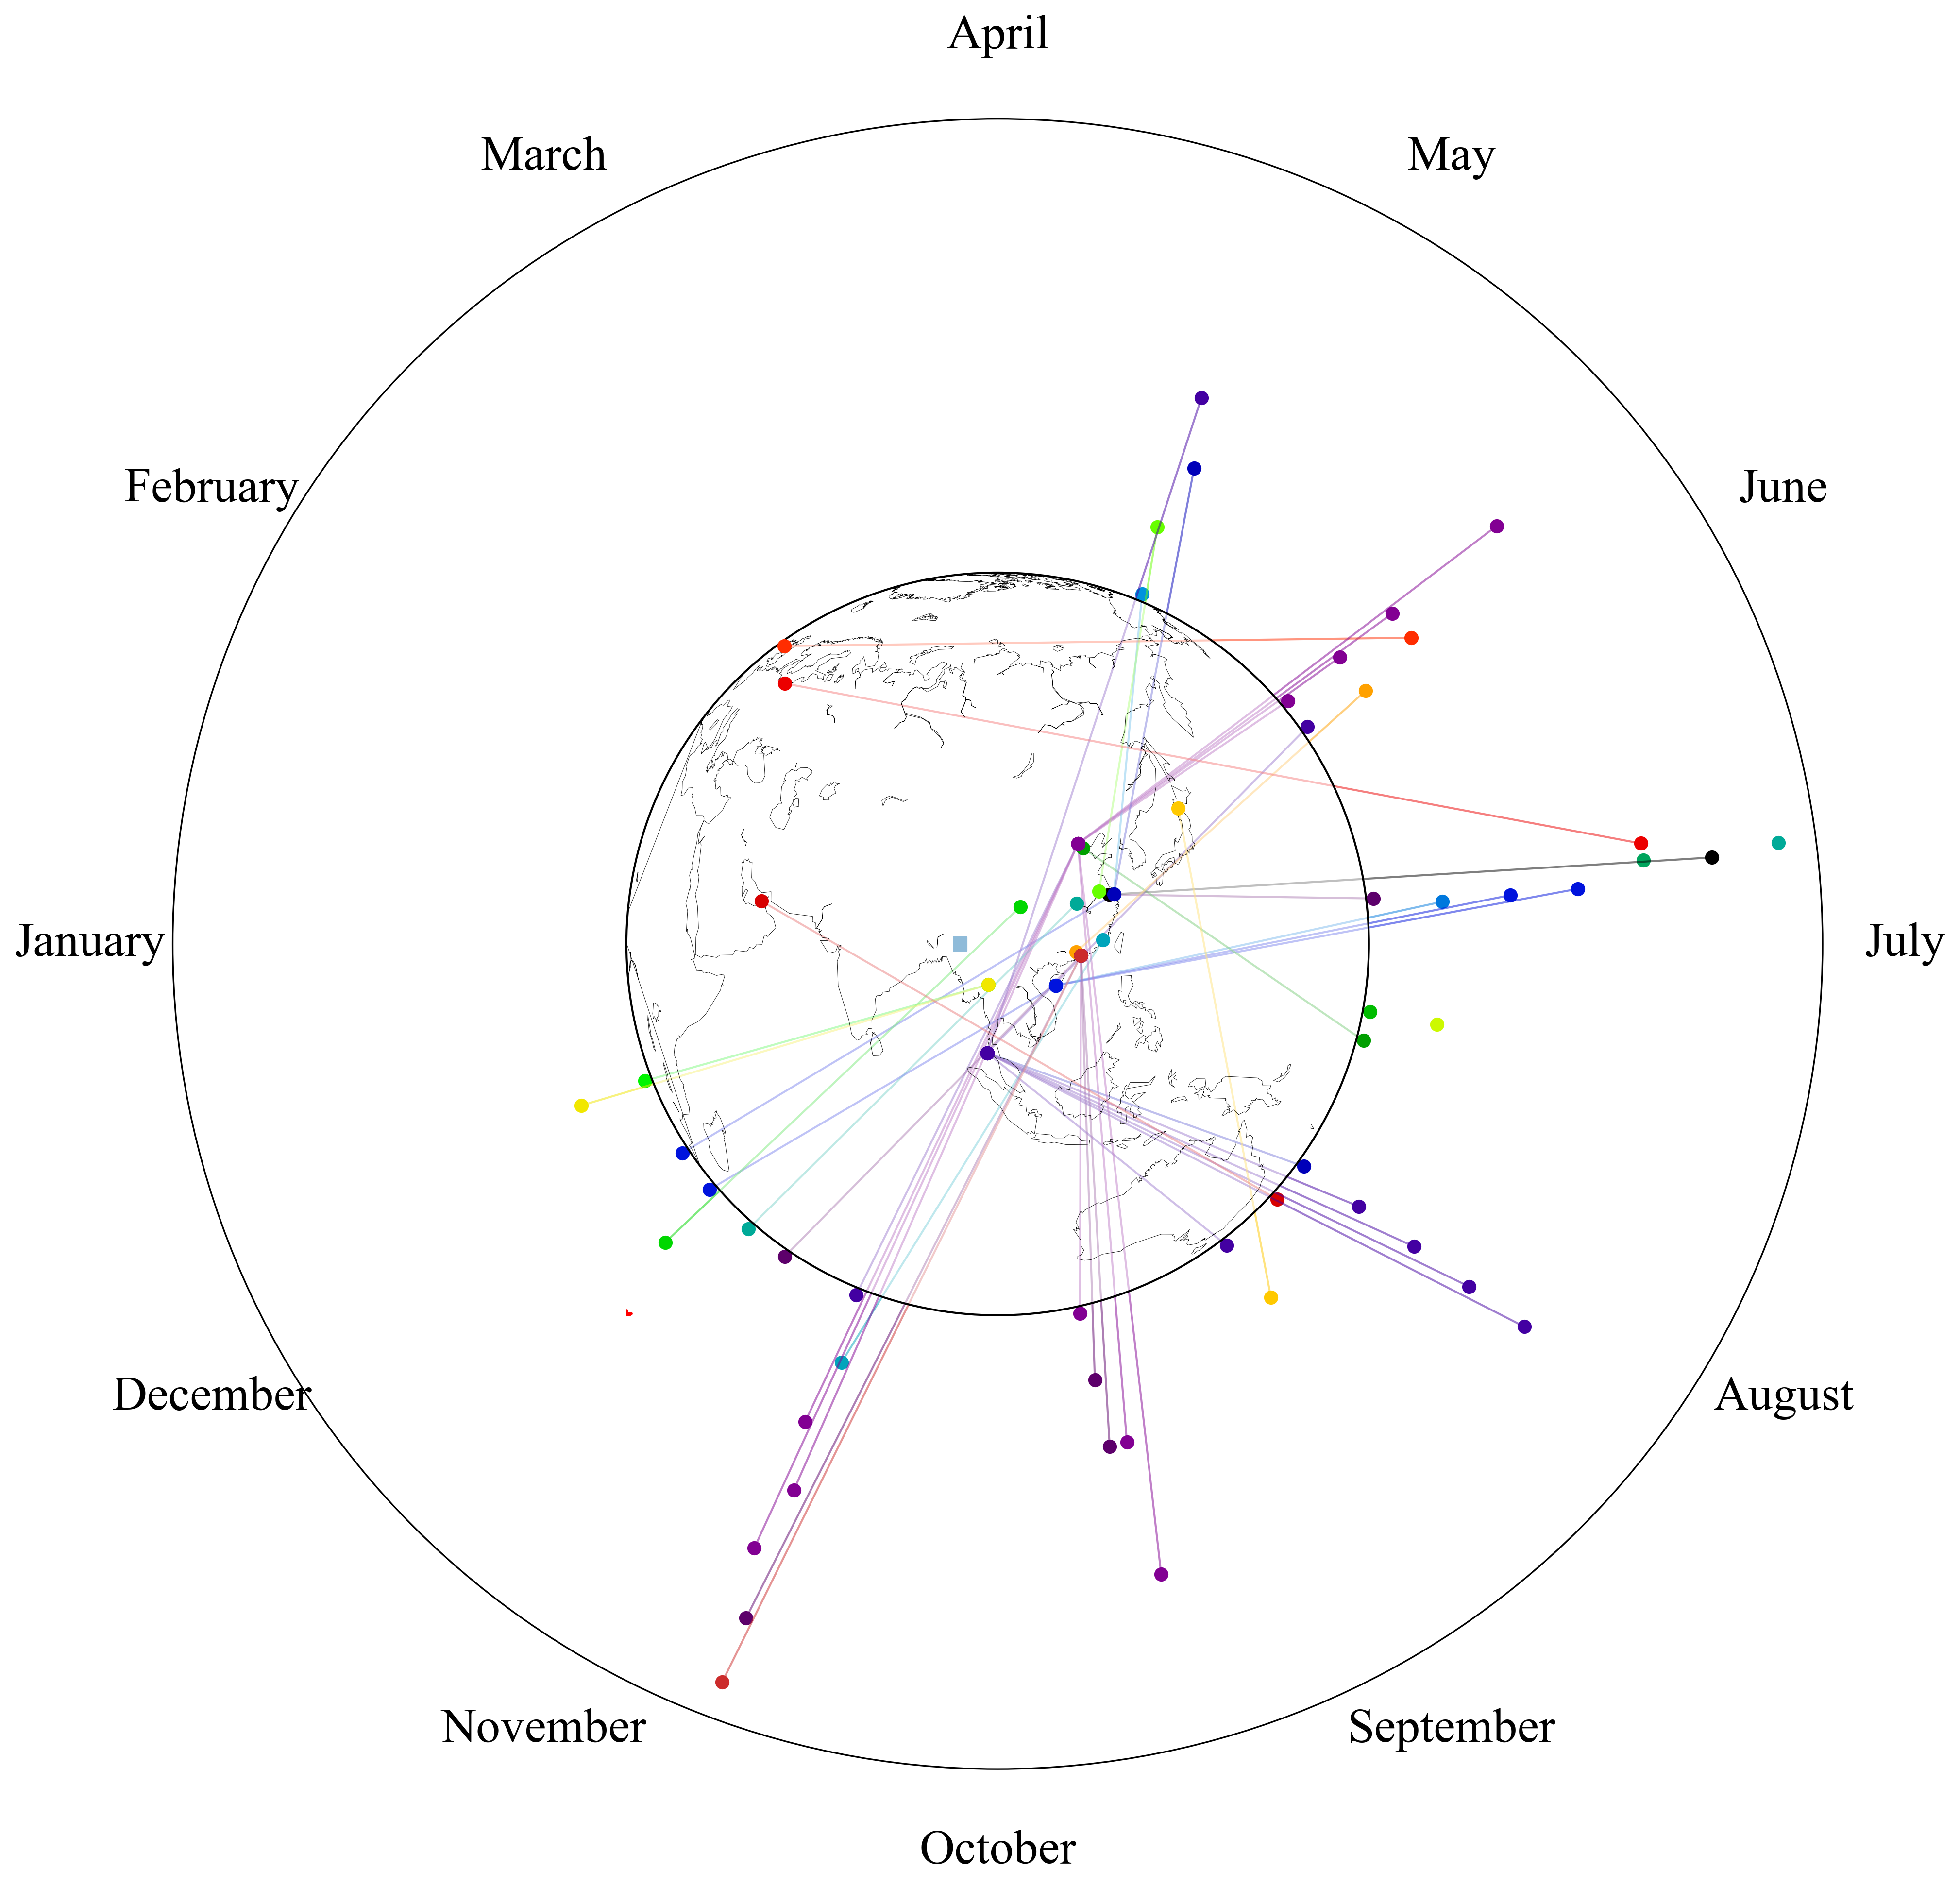

In [80]:
datafile = "FakeConferences.tsv"
# datafile = "testfile.csv"
conferencelist =[]
startlist = []
endlist = []
placelist = []
cmap = cm.get_cmap('nipy_spectral')

tstart = datetime.datetime(2017, 1, 1, 0, 0).timestamp()
tmid = datetime.datetime(2017, 7, 1, 0, 0).timestamp()
tend= datetime.datetime(2018, 1, 1, 0, 0).timestamp()
tdiff = tend - tstart

fig = plt.figure(figsize=(15, 15))
fig.dpi = 300
ax = plt.subplot(111, projection='polar')
ax.set_rmax(10)
ax.set_rticks([])  # less radial ticks
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1)
ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.set_thetagrids(np.arange(0, 361, 30), labels=[calendar.month_name[ii] for ii in range(1, 13)])
ax.grid(False)
ax.plot(0, 0, "s")

axin = inset_axes(ax, width="45%", height="45%", loc=10)
axin.patch.set_alpha(0.5)
axin.plot(1, 3, "*r")
axin.set_xticks([])
axin.set_yticks([])
m.ax = axin
m.drawcoastlines(linewidth=.2)

with open(datafile, 'r') as f:
    for lines in f:
        c = Conference(initials=lines.split('\t')[0],
                       name=lines.split('\t')[1],
                       place=lines.split('\t')[2])
        c.get_dates(lines.split('\t')[3])
        c.end += datetime.timedelta(days=1)
        c.get_location(lines.split('\t')[2])
        
        timestart = c.start.timestamp()
        timeend = c.end.timestamp()            
        # print(c.location)
        
        startlist.append(timestart)
        endlist.append(timeend)
        
        # Compute the number of overlaps
        
        noverlap = 0
        for start, end in zip(startlist, endlist):
            overlap = getOverlap([timestart, timeend], [start, end])
            if overlap:
                noverlap += 1
                #print(noverlap)
        
        try:
            placeindex = placelist.index(c.place)
        except ValueError:
            placelist.append(c.place)
            placeindex = len(placelist)

        thiscolor = cmap((placeindex/24))

        anglestart = get_angle_from_date(c.start)
        angleend = get_angle_from_date(c.end)
       
        ax.plot(.5 * (anglestart + angleend), 1.5 * noverlap + 6, "o", color=thiscolor)
        xy = (.5 * (anglestart + angleend), 1.5 * noverlap + 6)
        
        # Add the points to the map
        lon, lat = m(c.location[1], c.location[0])
        
        if lon < 1e30:
            m.plot(lon, lat, 'ko', latlon=False, color=thiscolor)
            xy2 = (lon, lat)
            con = ConnectionPatch(xyA=xy2, xyB=xy, coordsA="data", coordsB="data",
                  axesA=axin, axesB=ax, color=thiscolor, alpha=.5, zorder=2)
            ax.add_artist(con)
            
        else:
            pass
       
        
        #ax.text(.5 * (anglestart + angleend), 1.5 * noverlap + 6, 
        #     c.initials, horizontalalignment="right", 
        #     verticalalignment="center", 
        #     fontsize=20, zorder=4, color=thiscolor)

plt.savefig("conf_polar02")    
plt.show()
plt.close()